In [1]:
from keras.layers import Input, Dense
from keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from pandas import ExcelWriter
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Output.csv')
df = df.drop(columns = ['Unnamed: 0'])
df['Def'] = df.Default
df = df.drop(columns = ['Default'])
df.head()

,Debt_Apr_May,Debt_May_Jun,Debt_Jun_Jul,Debt_Jul_Aug,Debt_Aug_Sept,Def
0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,-1.0,-1.0,1.0,1.0
2,1.0,-1.0,-1.0,-1.0,1.0,0.0
3,-1.0,-1.0,1.0,-1.0,-1.0,0.0
4,1.0,-1.0,1.0,-1.0,1.0,0.0


In [3]:
encoding_dim = 3  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(6,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(6, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [7]:
cols = list(df.columns)
cols

['Debt_Apr_May',
 'Debt_May_Jun',
 'Debt_Jun_Jul',
 'Debt_Jul_Aug',
 'Debt_Aug_Sept',
 'Def']

In [8]:
X = df[cols[:]].values
y = df.Def.values

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(23985, 6)
(5997, 6)


In [11]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 23985 samples, validate on 5997 samples
Epoch 1/50
23985/23985 [==============================] - 0s 15us/step - loss: 0.7001 - val_loss: 0.5986
Epoch 2/50
23985/23985 [==============================] - 0s 6us/step - loss: 0.5098 - val_loss: 0.3987
Epoch 3/50
23985/23985 [==============================] - 0s 6us/step - loss: 0.2556 - val_loss: 0.0455
Epoch 4/50
23985/23985 [==============================] - 0s 6us/step - loss: -0.2965 - val_loss: -0.7807
Epoch 5/50
23985/23985 [==============================] - 0s 6us/step - loss: -1.1490 - val_loss: -1.4943
Epoch 6/50
23985/23985 [==============================] - 0s 6us/step - loss: -1.6869 - val_loss: -1.9498
Epoch 7/50
23985/23985 [==============================] - 0s 6us/step - loss: -2.1427 - val_loss: -2.4241
Epoch 8/50
23985/23985 [==============================] - 0s 6us/step - loss: -2.6541 - val_loss: -2.8939
Epoch 9/50
23985/23985 [==============================] - 0s

In [12]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

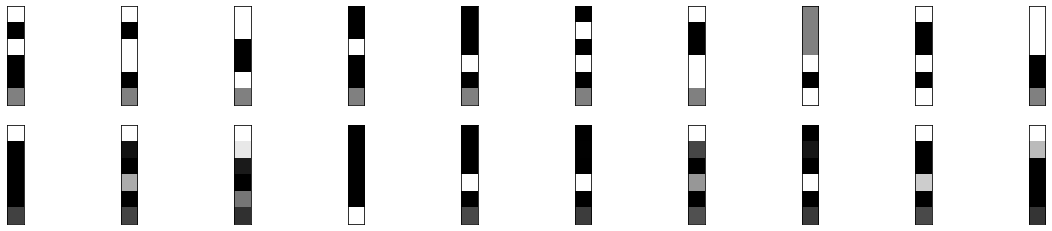

In [13]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(6, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(6, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
print(encoded_imgs)

[[ 7.565826  10.668968  11.965842 ]
 [ 6.149975   6.182042   1.6365685]
 [ 1.4187212  9.364634   4.0383253]
 ...
 [ 6.271212   9.880376   0.       ]
 [ 7.6945705 14.387291   4.624918 ]
 [ 7.6945705 14.38729    4.6249185]]


In [15]:
encoded_imgs.shape

(5997, 3)

In [21]:
df.head(2)

,Debt_Apr_May,Debt_May_Jun,Debt_Jun_Jul,Debt_Jul_Aug,Debt_Aug_Sept,Def
0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,-1.0,-1.0,-1.0,1.0,1.0


In [22]:
test = decoded_imgs[2,:]

In [23]:
test

array([1.        , 0.9067106 , 0.1033321 , 0.        , 0.46350592,
       0.19387648], dtype=float32)

In [24]:
decoded_imgs.shape

(5997, 6)

In [20]:
print(x_test)

[[ 1. -1.  1. -1. -1.  0.]
 [ 1. -1.  1.  1. -1.  0.]
 [ 1.  1. -1. -1.  1.  0.]
 ...
 [ 1.  1. -1.  1. -1.  0.]
 [ 1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1.]]
